In [1]:
import pandas as pd
import os
import numpy as np
import joblib
from functools import reduce
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance
from imblearn.over_sampling import RandomOverSampler
import shap
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, StratifiedKFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.multiclass import OneVsRestClassifier
# from skmultilearn.model_selection import MultiLabelStratifiedKFold
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from joblib import dump
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
# breed
feat_breed = pd.read_pickle('../features/breed.pkl')
feat_breed_v2 = pd.read_pickle('../features/breed_v2.pkl')

feat_breed_top50 = pd.read_pickle('../features/breed_top50.pkl')
feat_breed_top50_v2 = pd.read_pickle('../features/breed_top50_v2.pkl')

feat_breed_group = pd.read_pickle('../features/breed_group.pkl')
feat_sub_breed = pd.read_pickle('../features/sub_breed.pkl')
feat_breed_type = pd.read_pickle('../features/breed_type.pkl')

feat_breed_pure_or_mix = pd.read_pickle('../features/breed_pure_or_mix.pkl')

# age
feat_age = pd.read_csv('../features/age_with_id.csv')

# sex
feat_sex = pd.read_csv('../features/one_hot_encoded_sex_with_id.csv')

# weight
feat_weight = pd.read_pickle('../features/weight.pkl')

# Climate
# feat_HotWheater = pd.read_csv('../features/one_hot_encoded_HotWheater_with_id.csv')
# feat_ModerateWheather = pd.read_csv('../features/one_hot_encoded_ModerateWheather_with_id.csv')
# feat_ColdWheater_with_id = pd.read_csv('../features/one_hot_encoded_ColdWheater_with_id.csv')
feat_cold_month = pd.read_pickle('../features/ColdMonths.pkl')
feat_hot_month = pd.read_pickle('../features/HotMonths.pkl')

# Diet
feat_diet = pd.read_pickle('../features/diet.pkl') # 5 columns

# Physical Activity
feat_pa_total_hours = pd.read_csv('../features/PhysicalActivity_total_hours.csv')
feat_pa_surface = pd.read_csv('../features/PhysicalActivity_surface.csv')
feat_pa_wheather = pd.read_csv('../features/PhysicalActivity_wheather.csv')

# Owner Demographics
feat_od_income = pd.read_pickle('../features/od_income.pkl')
feat_od_education = pd.read_pickle('../features/od_education.pkl')

# Residentual
feat_prim_census_division = pd.read_pickle('../features/primary_residence_census_division.pkl')

# disease
feat_disease_input = pd.read_csv('../features/one_hot_encoded_disease_input.csv')
feat_disease_output_binary = pd.read_csv('../features/disease_output_binary.csv')
feat_disease_output = pd.read_csv('../features/disease_output.csv')

# age_condition
feat_age_condition = pd.read_pickle('../features/age_condition.pkl')
feat_age_condition_type = pd.read_pickle('../features/age_condition_type.pkl')


features_list = [

    # breed
    #feat_breed,
    #feat_breed_v2,
    #feat_breed_top50,
    #feat_breed_top50_v2,
    #feat_breed_group,
    #feat_sub_breed,
    #feat_breed_type,
    #feat_breed_pure_or_mix,

    # age
    #feat_age,   # 24881 dog_ids

    # sex
    #feat_sex,

    # weight
    #feat_weight

    # diet
    #feat_diet,  # 33141 dog_ids for df_diet_consistency

    #feat_HotWheater,
    #feat_ModerateWheather,
    #feat_ColdWheater_with_id,

    # Climate
    #feat_hot_month,
    #feat_cold_month,

    # Physical Activity
    #feat_pa_total_hours,
    #feat_pa_surface,
    #feat_pa_wheather,   # 26406 dog_ids

    # Owner demographics
    #feat_od_income,    # 29096 dog_ids
    #feat_od_education

    # Residentual
    feat_prim_census_division,  # 33136 dog_ids

    # disease
    #feat_disease_input,
    #feat_disease_output_binary,
    #feat_disease_output
]

feat_age_condition_type

,dog_id,age_diagnosis_years,condition_type_Bone/Orthopedic,condition_type_Brain/Neurologic,condition_type_Cardiac,condition_type_Ear/Nose/Throat,condition_type_Endocrine,condition_type_Eye,condition_type_Gastrointestinal,condition_type_Hematopoietic,...,condition_type_Kidney/Urinary,condition_type_Liver/Pancreas,condition_type_Mouth/Dental/Oral,condition_type_Other Congenital Disorder,condition_type_Reproductive,condition_type_Respiratory,condition_type_Skin,condition_type_Toxin Consumption,condition_type_Trauma,condition_type_cancer
0,100001,0,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,100001,1,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,100001,2,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,100001,3,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,100001,4,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
910915,3373,10,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
910929,14856,10,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
910936,58327,6,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
910945,3417,1,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True


In [3]:
exp1 = []
exp2 = [feat_breed_top50_v2]
exp3 = [feat_breed_group]
exp4 = [feat_breed_type, feat_sub_breed, feat_breed_pure_or_mix]
exp5 = [feat_breed_top50_v2, feat_breed_group, feat_breed_type, feat_sub_breed, feat_breed_pure_or_mix,
        feat_age]
exp6 = [feat_breed_top50_v2, feat_breed_group, feat_breed_type, feat_sub_breed, feat_breed_pure_or_mix,
        feat_age, feat_sex]
exp7 = [feat_breed_top50_v2, feat_breed_group, feat_breed_type, feat_sub_breed, feat_breed_pure_or_mix,
        feat_age, feat_weight]
exp8 = [feat_breed_top50_v2, feat_breed_group, feat_breed_type, feat_sub_breed, feat_breed_pure_or_mix,
        feat_age, feat_sex, feat_weight, feat_hot_month, feat_cold_month]
exp9 = [feat_breed_top50_v2, feat_breed_group, feat_breed_type, feat_sub_breed, feat_breed_pure_or_mix,
        feat_age, feat_sex, feat_weight, feat_prim_census_division]
exp10 = [feat_breed_top50_v2, feat_breed_group, feat_breed_type, feat_sub_breed, feat_breed_pure_or_mix,
         feat_age, feat_weight, feat_cold_month, feat_hot_month, feat_prim_census_division]
exp11 = [feat_breed_top50_v2, feat_breed_group, feat_breed_type, feat_sub_breed, feat_breed_pure_or_mix,
         feat_age, feat_sex, feat_weight,
         feat_cold_month, feat_hot_month,
         feat_prim_census_division,
         feat_pa_surface, feat_pa_total_hours]
exp12 = [feat_breed_top50_v2, feat_breed_group, feat_breed_type, feat_sub_breed, feat_breed_pure_or_mix,
         feat_age, feat_sex, feat_weight,
         feat_cold_month, feat_hot_month,
         feat_prim_census_division,
         feat_diet]
exp13 = [feat_breed_top50_v2, feat_breed_group, feat_breed_type, feat_sub_breed, feat_breed_pure_or_mix,
         feat_age, feat_sex, feat_weight,
         feat_cold_month, feat_hot_month,
         feat_prim_census_division,
         feat_pa_surface, feat_pa_total_hours,
         feat_diet]
exp14 = [feat_breed_top50_v2, feat_breed_group, feat_breed_type, feat_sub_breed, feat_breed_pure_or_mix,
         feat_age, feat_sex, feat_weight,
         feat_cold_month, feat_hot_month,
         feat_prim_census_division,
         feat_pa_surface, feat_pa_total_hours,
         feat_diet,
         feat_od_education, feat_od_income]
exp15 = [feat_breed_top50_v2, feat_breed_group, feat_breed_type, feat_sub_breed, feat_breed_pure_or_mix,
         feat_age, feat_sex,
         feat_pa_surface, feat_pa_total_hours,
         feat_diet
         ]


In [4]:
experiments = {
    'exp1': exp1,
    'exp2': exp2,
    'exp3': exp3,
    'exp4': exp4,
    'exp5': exp5,
    'exp6': exp6,
    'exp7': exp7,
    'exp8': exp8,
    'exp9': exp9,
    'exp10': exp10,
    'exp11': exp11,
    'exp12': exp12,
    'exp13': exp13,
    'exp14': exp14,
    #'exp15': exp15,
    #'exp16': exp16,
    #'exp17': exp17,
    #'exp18': exp18,
    #'exp19': exp19,
    #'exp20': exp20,
    #'exp21': exp21
}


In [5]:
exp_features = experiments['exp14']

In [6]:
 # List of DataFrames to be merged
list_input_features = features_list  # Add more DataFrames as needed

# Merge DataFrames iteratively using reduce
input_features = reduce(lambda left, right: pd.merge(left, right, on='dog_id'), exp_features)

# Merge with disease output feature
# data = pd.merge(input_features, feat_disease_output_binary, on='dog_id')
data = pd.merge(feat_age_condition_type, input_features, on='dog_id')
data

,dog_id,age_diagnosis_years,condition_type_Bone/Orthopedic,condition_type_Brain/Neurologic,condition_type_Cardiac,condition_type_Ear/Nose/Throat,condition_type_Endocrine,condition_type_Eye,condition_type_Gastrointestinal,condition_type_Hematopoietic,...,sand,astroturf,total_active_hours,df_feedings_per_day,df_diet_consistency,df_supplements,df_primary_diet_component_organic,df_primary_diet_component_grain_free,od_max_education,od_annual_income_range_usd
0,100004,0,False,False,False,False,False,False,False,False,...,False,False,1.0,1,1.0,True,False,True,10,10.0
1,100004,1,False,False,False,False,False,False,False,False,...,False,False,1.0,1,1.0,True,False,True,10,10.0
2,100004,2,False,False,False,False,False,False,False,False,...,False,False,1.0,1,1.0,True,False,True,10,10.0
3,100004,3,False,False,False,False,False,False,False,False,...,False,False,1.0,1,1.0,True,False,True,10,10.0
4,100005,0,False,False,False,False,False,False,False,False,...,False,False,3.0,2,1.0,False,False,True,7,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209000,77040,3,False,False,False,False,False,False,False,False,...,False,False,2.0,3,1.0,False,False,True,7,10.0
209001,77040,4,False,False,False,False,False,False,False,False,...,False,False,2.0,3,1.0,False,False,True,7,10.0
209002,77040,5,False,False,False,False,False,False,False,False,...,False,False,2.0,3,1.0,False,False,True,7,10.0
209003,77040,6,False,False,False,False,False,False,False,False,...,False,False,2.0,3,1.0,False,False,True,7,10.0


In [7]:
# Check for NaN values
rows_with_nan = data[data.isna().any(axis=1)]
columns_with_nan = data.columns[data.isna().any()].tolist()
# Display the rows with NaN values
rows_with_nan[columns_with_nan]

""


In [8]:
from joblib import load
X = data.drop(['dog_id'] + ['condition_type_' + condition_type for condition_type in [
    'Eye', 'Ear/Nose/Throat', 'Mouth/Dental/Oral', 'Skin', 'Cardiac', 'Respiratory',
    'Gastrointestinal', 'Liver/Pancreas', 'Kidney/Urinary', 'Reproductive', 'Bone/Orthopedic',
    'Brain/Neurologic', 'Endocrine', 'Hematopoietic', 'Other Congenital Disorder',
    'Infection/Parasites', 'Toxin Consumption', 'Trauma', 'Immune-mediated', 'cancer'
    ]], axis=1)

y_columns = ['condition_type_' + condition_type for condition_type in [
    'Eye', 'Ear/Nose/Throat', 'Mouth/Dental/Oral', 'Skin', 'Cardiac', 'Respiratory',
    'Gastrointestinal', 'Liver/Pancreas', 'Kidney/Urinary', 'Reproductive', 'Bone/Orthopedic',
    'Brain/Neurologic', 'Endocrine', 'Hematopoietic', 'Other Congenital Disorder',
    'Infection/Parasites', 'Toxin Consumption', 'Trauma', 'Immune-mediated', 'cancer'
    ]]

y = data[y_columns]

# Convert y to a binary format
y_binary = (y == 1)

# Select all features for normalization
features_to_normalize_columns = X.columns

#print(len(features_to_normalize_columns))

# Remove the target variable if it's present in the list
features_to_normalize = [feature for feature in features_to_normalize_columns]

# Initialize MinMaxScaler
scaler = MinMaxScaler()
# loaded_scaler = load('../models/scaler.joblib')
#scaler = StandardScaler()

 # Normalize
if features_to_normalize:
    X[features_to_normalize] = scaler.fit_transform(data[features_to_normalize])
    # X[features_to_normalize] = loaded_scaler.transform(data[features_to_normalize]) 
    print(data[features_to_normalize])


        age_diagnosis_years  breeds_American Pitbull Terrier  \
0                         0                                0   
1                         1                                0   
2                         2                                0   
3                         3                                0   
4                         0                                0   
...                     ...                              ...   
209000                    3                                0   
209001                    4                                0   
209002                    5                                0   
209003                    6                                0   
209004                    7                                0   

        breeds_American Staffordshire Terrier  breeds_Australian Cattle Dog  \
0                                           0                             0   
1                                           0                            

In [9]:
# loading model
model = joblib.load('../models/extreme_gradient_boosting_no_false.joblib')

[12:40:50] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:553: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.

[12:40:50] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:553: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about d

Trying to unpickle estimator LabelBinarizer from version 1.4.0 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
Trying to unpickle estimator OneVsRestClassifier from version 1.4.0 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations


In [10]:
# Initialize MultilabelStratifiedKFold
n_splits = 5  # You can adjust the number of splits as needed
ml_stratified_kfold = MultilabelStratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

train_index, val_index = next(iter(ml_stratified_kfold.split(X, y_binary)))

X_train, X_val = X.iloc[train_index], X.iloc[val_index]
y_train, y_val = y_binary.iloc[train_index], y_binary.iloc[val_index]

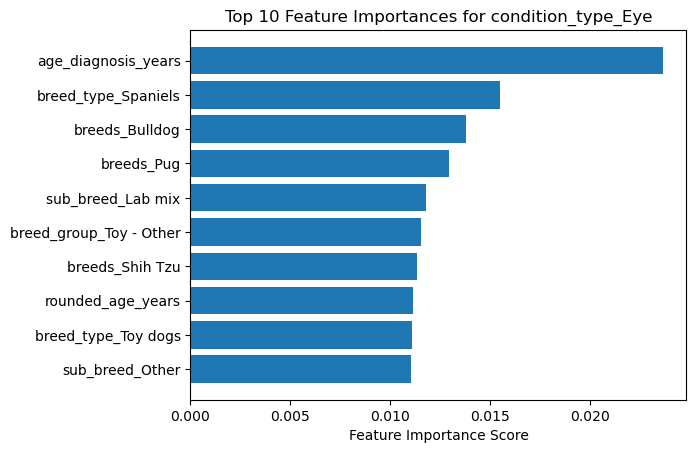

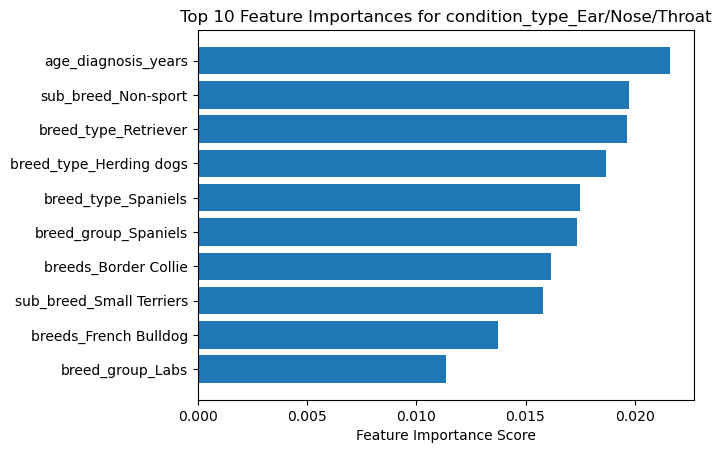

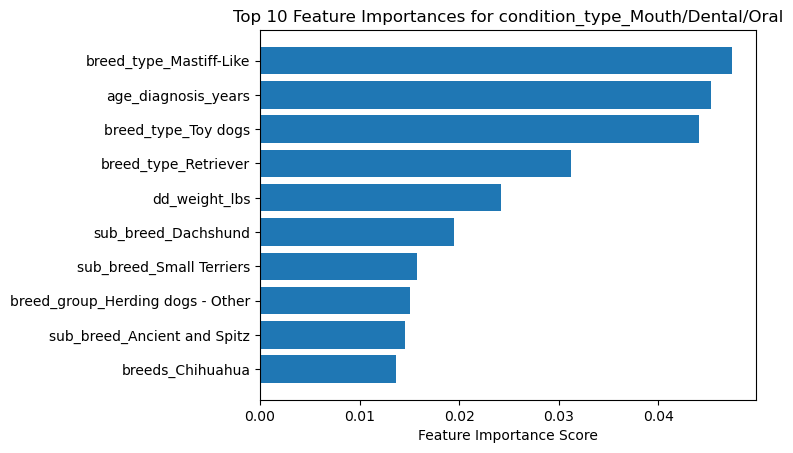

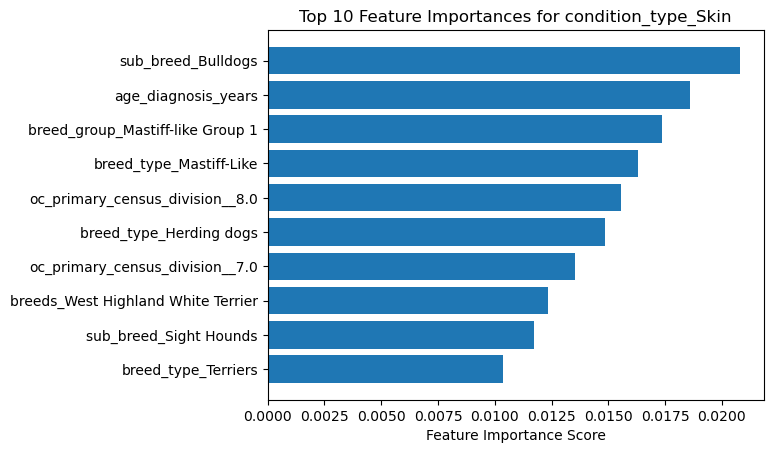

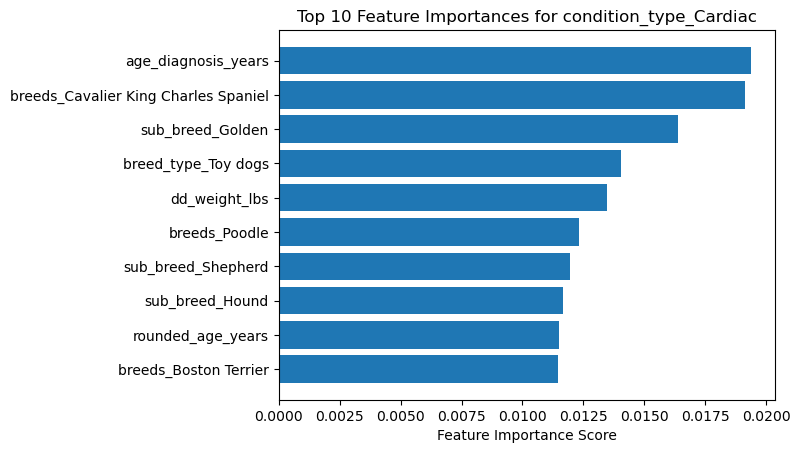

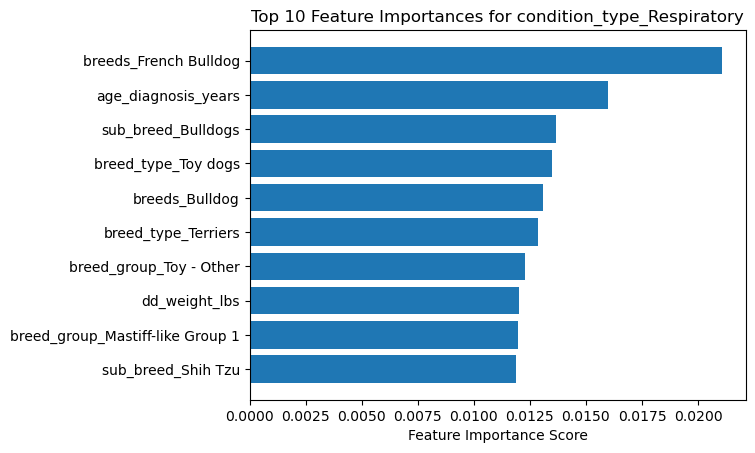

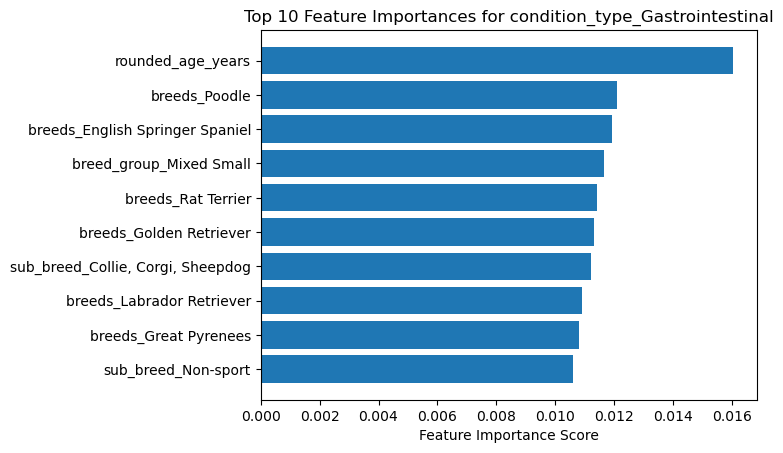

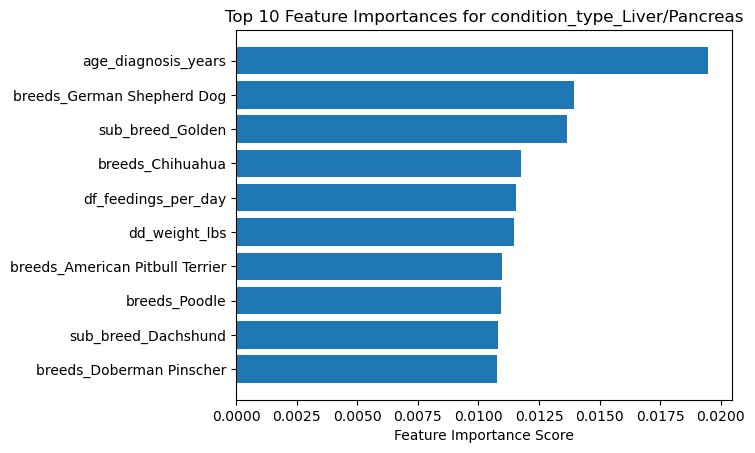

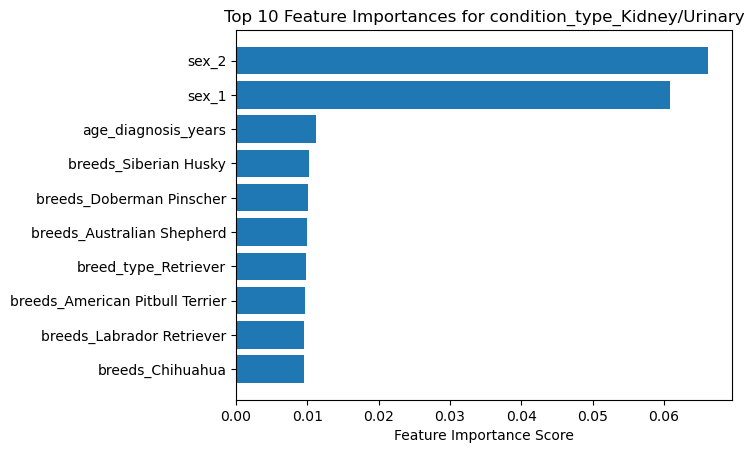

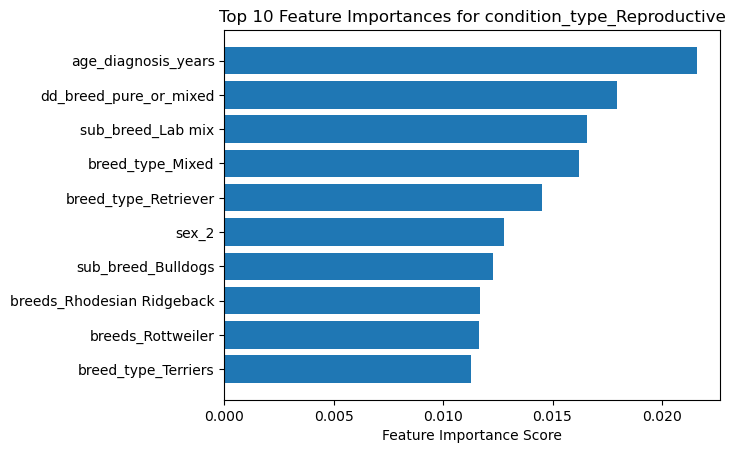

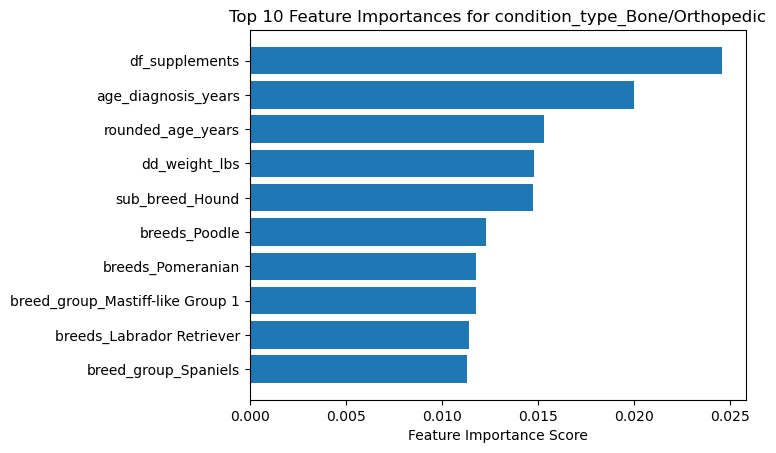

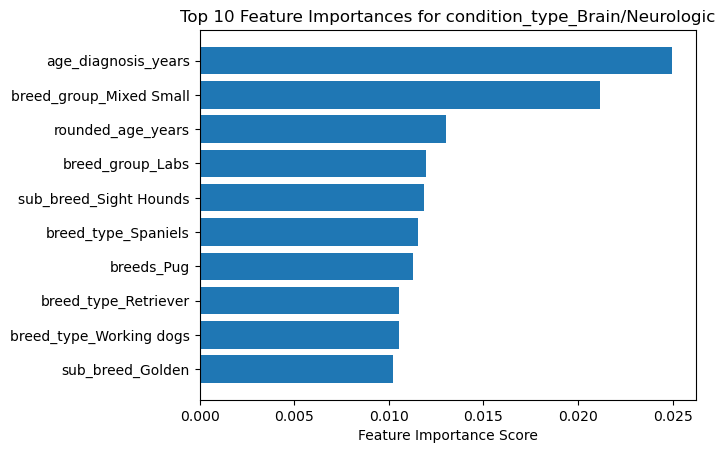

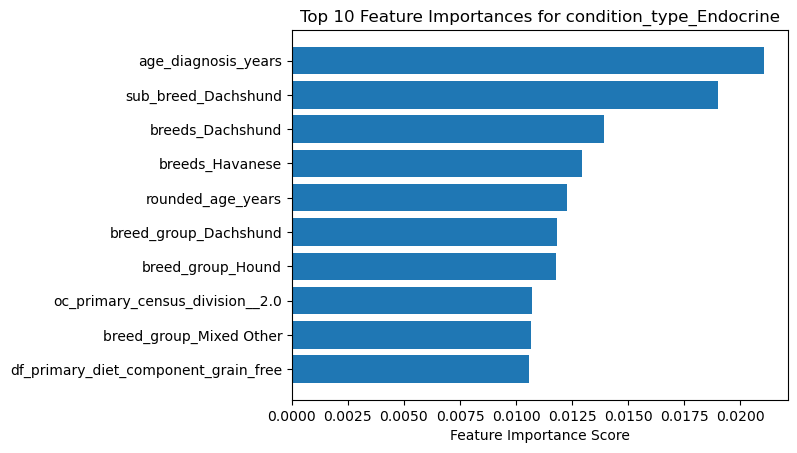

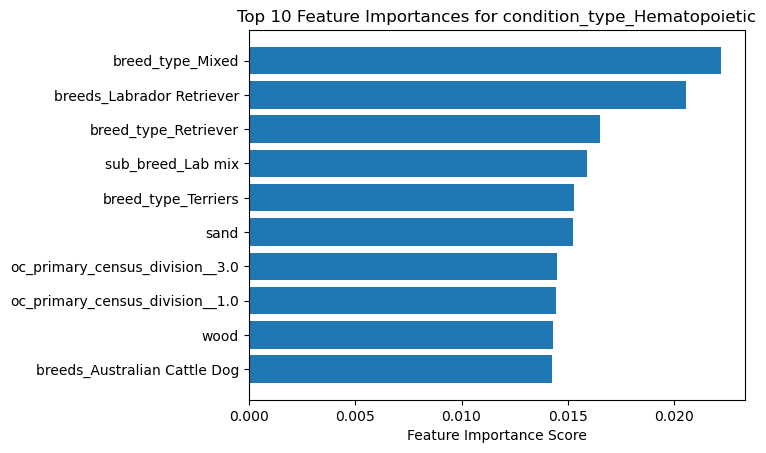

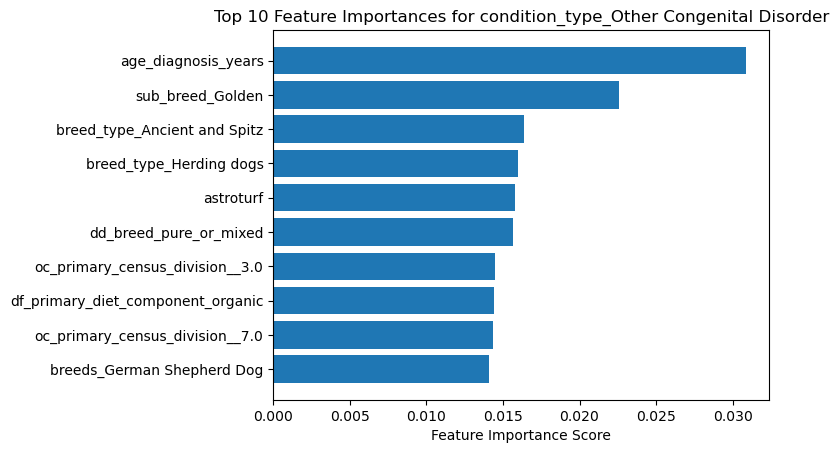

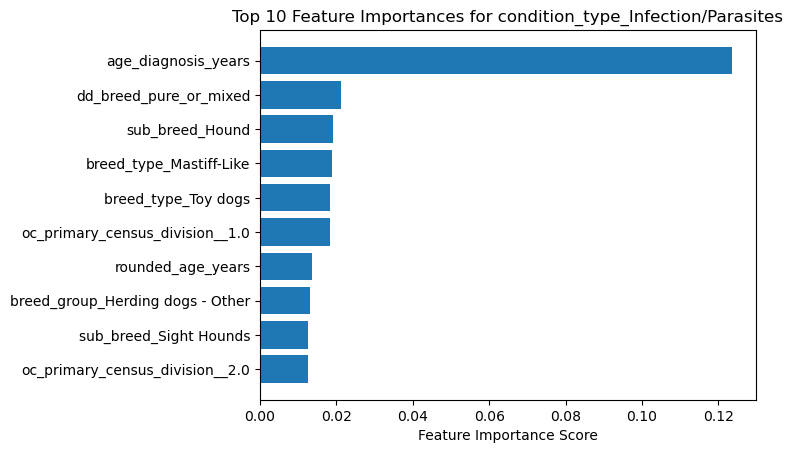

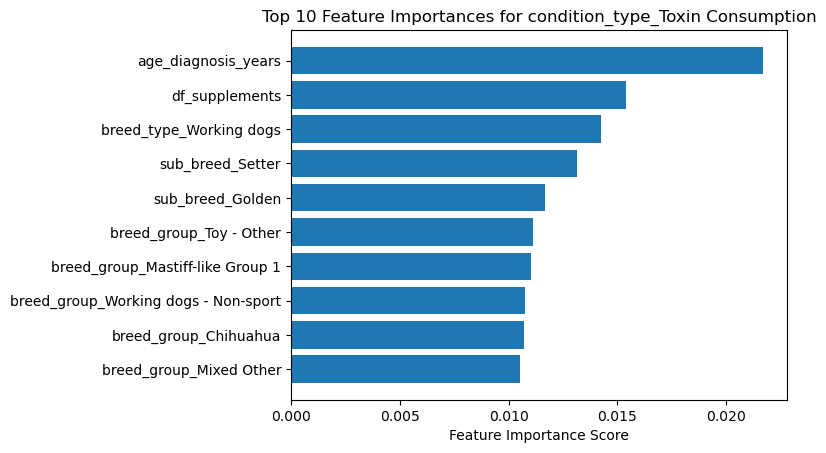

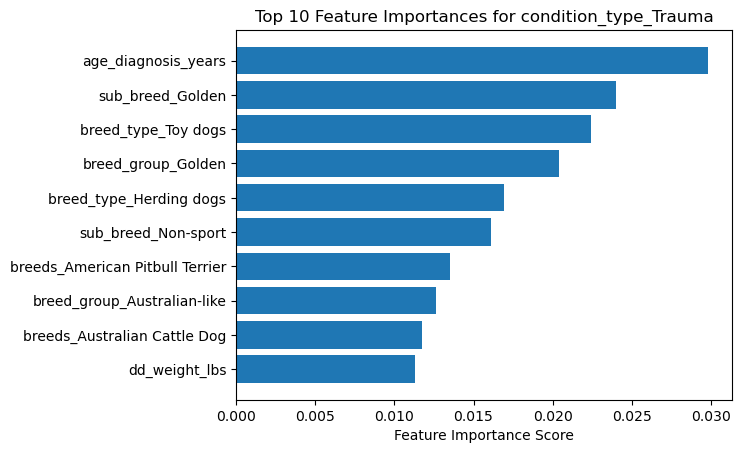

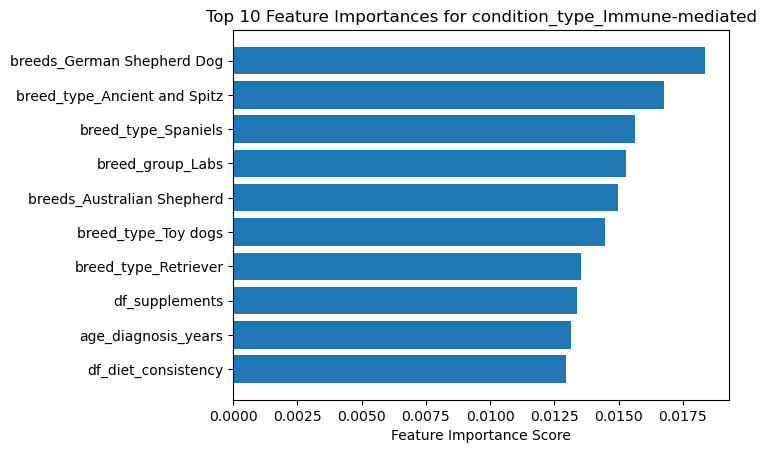

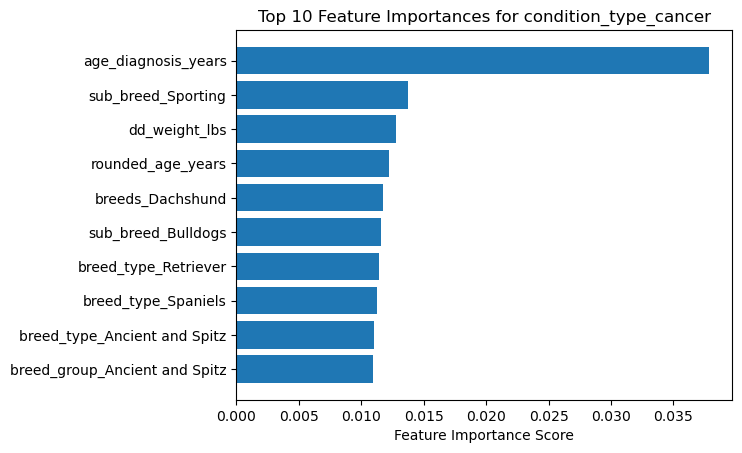

In [12]:
# ovr = OneVsRestClassifier(model)

# ovr.fit(X_train, y_train)

for i, label in enumerate(y.columns):
    sub_model = model.estimators_[i]
    
    feature_importances = sub_model.feature_importances_
    sorted_idx = np.argsort(feature_importances)[-10:]
    
    plt.figure()
    plt.barh(range(10), feature_importances[sorted_idx], align='center')
    plt.yticks(range(10), X_train.columns[sorted_idx])
    plt.xlabel('Feature Importance Score')
    plt.title(f'Top 10 Feature Importances for {label}')
    plt.show()